In [374]:
import numpy as np
import torch
import torchsde
from torch import nn
import diffeq_layers 
import torchdiffeq
import utils


class YNetWithSplit(nn.Module):
    def __init__(self, *blocks):
        # Or create the blocks in side this function given the input size and other hparams
        # Each block has a split module at the end, which does t1, t2 = t.chunk(dim=1, chunks=2).
        pass

    def forward(self, x):
        zs = []
        net = x
        for block in self.blocks:
            z1, z2 = block(net)
            zs.append(z2)
            net = z1
        return zs  # Or cat along non-batch dimension.


def make_y_net(input_size,
               blocks=(2, 2, 2),
               activation="softplus",
               verbose=False,
               explicit_params=True,
               hidden_width=128,
               aug_dim=0,
               mode=0):
    
    """This is the bayesian neural network"""

    _input_size = (input_size[0] + aug_dim,) + input_size[1:]
    layers = []

    for i, num_blocks in enumerate(blocks, 1):
        for j in range(1, num_blocks + 1):
            layers.extend(diffeq_layers.make_ode_k3_block_layers(input_size=_input_size,
                                                                 activation=activation,
                                                                 last_activation=i < len(blocks) or j < num_blocks,
                                                                 hidden_width=hidden_width,
                                                                 mode=mode)) # mode 1 for MNIST; 0 for cifar10

            if verbose:
                if i == 1:
                    print(f"y_net (augmented) input size: {_input_size}")
                layers.append(diffeq_layers.Print(name=f"group: {i}, block: {j}"))

        if i < len(blocks):
            layers.append(diffeq_layers.ConvDownsample(_input_size))
            _input_size = _input_size[0] * 4, _input_size[1] // 2, _input_size[2] // 2

    y_net = diffeq_layers.DiffEqSequential(*layers, explicit_params=explicit_params)

    # return augmented input size b/c y net should have same input / output
    return y_net, _input_size


def make_w_net(in_features, hidden_sizes=(1, 64, 1), activation="softplus", inhomogeneous=True):

    """This is the network that evolves the weights"""

    activation = utils.select_activation(activation)
    all_sizes = (in_features,) + tuple(hidden_sizes) + (in_features,)

    if inhomogeneous:
        layers = []
        for i, (in_size, out_size) in enumerate(zip(all_sizes[:-1], all_sizes[1:]), 1):
            layers.append(diffeq_layers.Linear(in_size, out_size))
            if i + 1 < len(all_sizes):
                layers.append(diffeq_layers.DiffEqWrapper(activation()))
            else:  # Last layer needs zero initialization.
                nn.init.zeros_(layers[-1].weight)
                nn.init.zeros_(layers[-1].bias)
        return diffeq_layers.DiffEqSequential(*layers, explicit_params=False)
    
    else:
        layers = []
        for i, (in_size, out_size) in enumerate(zip(all_sizes[:-1], all_sizes[1:]), 1):
            layers.append(nn.Linear(in_size, out_size))
            if i + 1 < len(all_sizes):
                layers.append(activation())
            else:  # Last layer needs zero initialization.
                nn.init.zeros_(layers[-1].weight)
                nn.init.zeros_(layers[-1].bias)
        return diffeq_layers.DiffEqWrapper(nn.Sequential(*layers))


class BaselineYNet(nn.Module):
    def __init__(self, input_size=(3, 32, 32), num_classes=10, activation="softplus", residual=False, hidden_width=128,
                 aug=0):
        super(BaselineYNet, self).__init__()
        y_net, output_size = make_y_net(
            input_size=input_size, explicit_params=False, activation=activation, hidden_width=hidden_width)
        self.projection = nn.Sequential(
            nn.Flatten(),
            nn.Linear(int(np.prod(output_size)) + aug, num_classes)
        )
        self.y_net = y_net
        self.residual = residual

    def forward(self, y, *args, **kwargs):
        t = y.new_tensor(0.)
        outs = self.y_net(t, y).flatten(start_dim=1)
        if self.residual:
            outs += y.flatten(start_dim=1)
        return self.projection(outs), torch.tensor(0., device=y.device)


# TODO: add STL
#class SDENet(torchsde.SDEStratonovich):
class SDENet(torchsde.SDEIto):
    def __init__(self,
                 input_size=(3, 32, 32),
                 blocks=(2, 2, 2),
                 weight_network_sizes=(1, 64, 1),
                 num_classes=10,
                 activation="softplus",
                 verbose=False,
                 inhomogeneous=True,
                 sigma=0.1,
                 hidden_width=128,
                 aug_dim=0,
                 mode=0):
        super(SDENet, self).__init__(noise_type="diagonal")
        self.input_size = input_size
        self.aug_input_size = (aug_dim + input_size[0], *input_size[1:])
        self.aug_zeros_size = (aug_dim, *input_size[1:])
        self.register_buffer('aug_zeros', torch.zeros(size=(1, *self.aug_zeros_size)))

        # Create network evolving state.
        self.y_net, self.output_size = make_y_net(
            input_size=input_size,
            blocks=blocks,
            activation=activation,
            verbose=verbose,
            hidden_width=hidden_width,
            aug_dim=aug_dim,
            mode=mode,
        )
        # Create network evolving weights.
        initial_params = self.y_net.make_initial_params()  # w0.
        flat_initial_params, unravel_params = utils.ravel_pytree(initial_params)
        self.flat_initial_params = nn.Parameter(flat_initial_params, requires_grad=True)
        self.params_size = flat_initial_params.numel()
        print(f"initial_params ({self.params_size}): {flat_initial_params.shape}")
        self.unravel_params = unravel_params
        self.w_net = make_w_net(
            in_features=self.params_size,
            hidden_sizes=weight_network_sizes,
            activation="tanh",
            inhomogeneous=inhomogeneous
        )

        # Final projection layer.
        self.projection = nn.Sequential(
            nn.Flatten(),
            # nn.Linear(int(np.prod(self.output_size)), num_classes), # option: projection w/o ReLU
            nn.Linear(int(np.prod(self.output_size)), 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, num_classes),
            #nn.Softmax(dim=1), # Add softmax activation
        )

        self.register_buffer('ts', torch.tensor([0., 1.]))
        self.sigma = sigma
        self.nfe = 0

    def f(self, t, y: torch.Tensor):
        input_y = y
        self.nfe += 1
        y, w, _ = y.split(split_size=(y.numel() - self.params_size - 1, self.params_size, 1), dim=1) # params_size: 606408


        print(y.reshape((-1, *self.aug_input_size)).reshape(-1).unsqueeze(0).shape, 'y')
        fy = self.y_net(t, y.reshape((-1, *self.aug_input_size)), self.unravel_params(w.squeeze(0))).reshape(-1).unsqueeze(0)
        nn = self.w_net(t, w)
        fw = nn - w  # hardcoded OU prior on weights w
        fl = (nn ** 2).sum(dim=1, keepdim=True) / (self.sigma ** 2)
        print(fy.shape, fw.shape, fl.shape, 'fy')

        assert input_y.shape == torch.cat([fy, fw, fl], dim=1).shape, f"Want: {input_y.shape} Got: {torch.cat((fy, fw, fl)).shape}. Check nblocks for dataset divisibility.\n"
        return torch.cat([fy, fw, fl], dim=1)#.squeeze(0)

    def g(self, t, y):
        self.nfe += 1
        gy = torch.zeros(size=(y.numel() - self.params_size - 1,), device=y.device)
        gw = torch.full(size=(self.params_size,), fill_value=self.sigma, device=y.device)
        gl = torch.tensor([0.], device=y.device)
        
        return torch.cat([gy, gw, gl], dim=0).unsqueeze(0)

    def make_initial_params(self):
        return self.y_net.make_initial_params()

    def forward(self, y, adjoint=False, dt=0.02, adaptive=False, adjoint_adaptive=False, method="euler", rtol=1e-4, atol=1e-3): # method="midpoint"
        # Note: This works correctly, as long as we are requesting the nfe after each gradient update.
        #  There are obviously cleaner ways to achieve this.
        self.nfe = 0    
        sdeint = torchsde.sdeint_adjoint if adjoint else torchsde.sdeint
        
        if self.aug_zeros.numel() > 0:  # Add zero channels.
            aug_zeros = self.aug_zeros.expand(y.shape[0], *self.aug_zeros_size)
            y = torch.cat([y, aug_zeros], dim=1) # 235200
        aug_y = torch.cat((y.reshape(-1), self.flat_initial_params, torch.tensor([0.], device=y.device))) # 841609: (235200, 606408, 1)
        aug_y = aug_y[None]
        
        bm = torchsde.BrownianInterval(
            t0=self.ts[0], t1=self.ts[-1], size=aug_y.shape, dtype=aug_y.dtype, device=aug_y.device,
            cache_size=45 if adjoint else 30  # If not adjoint, don't really need to cache.
        )
        
        if adjoint_adaptive:
            _, aug_y1 = sdeint(self, aug_y, self.ts, bm=bm, method=method, dt=dt, adaptive=adaptive, adjoint_adaptive=adjoint_adaptive, rtol=rtol, atol=atol)
        else:
            _, aug_y1 = sdeint(self, aug_y, self.ts, bm=bm, method=method, dt=dt, adaptive=adaptive, rtol=rtol, atol=atol)
        
        
        y1 = aug_y1[:,:y.numel()].reshape(y.size())
        logits = self.projection(y1)

        logqp = .5 * aug_y1[:, -1]
        
        return logits, logqp

    def zero_grad(self) -> None:
        for p in self.parameters(): p.grad = None

In [375]:
import jax 
import jax.numpy as np
import numpy as onp
import numpy.random as npr


def build_toy_dataset(key, test_n_data, batch_size, x_lim=[0, 6],  n_data=40, noise_std=0.1):
    """Time series data with gap for visualizing uncertainty.
    """
    rs = npr.RandomState(0)
    inputs  = np.concatenate([np.linspace(x_lim[0], 2, num=n_data//2),
                            np.linspace(x_lim[-1], 8, num=n_data//2)])
    true_fn = lambda x: np.cos(x)
    targets = true_fn(inputs) + rs.randn(n_data) * noise_std
    inputs = (inputs - 4.0) / 4.0
    inputs  = inputs.reshape((len(inputs), 1)) # (40, 1)
    targets = targets.reshape((len(targets), 1)) # (40, 1)

    # test set
    D = inputs.shape[-1]
    test_x0 = np.repeat(
        onp.expand_dims(np.linspace(x_lim[0] - 2, x_lim[1] + 2, test_n_data), axis=1), D, axis=1)  # (N, D)
    test_x0 = (test_x0 - 4.0) / 4.0
    test_x1 = onp.repeat(np.expand_dims(true_fn(test_x0[:, 0]), axis=1), D, axis=1) # (N, D)
    test = (test_x0, test_x1)

    def get_batch(key, test_n_data, batch_size, D=1):
        assert test_n_data % batch_size == 0
        num_batches = test_n_data / batch_size
        batch_x = onp.random.uniform(size=(batch_size, D), low=x_lim[0], high=x_lim[1]) # (bs, D)
        batch_x = (batch_x - 4.0) / 4.0
        batch_y = onp.repeat(true_fn(batch_x[:, 0])[..., None], D, axis=1) # (bs, D)

        return 1, (batch_x, batch_y)

    return inputs, targets, test, get_batch, noise_std

In [616]:
def make_y_net2(input_size, hidden_dim, activation, aug_dim=2):

   
    _input_size = (input_size[0] + aug_dim,) + input_size[1:]
    layers = diffeq_layers.DiffEqSequential(diffeq_layers.ConcatSquashLinear(_input_size[0], hidden_dim),
                                            diffeq_layers.DiffEqWrapper(nn.Swish),
                                            diffeq_layers.ConcatSquashLinear(hidden_dim, _input_size[0]),
                                            diffeq_layers.DiffEqWrapper(activation))
    
    return layers


In [633]:
import numpy as np
import torch
import torchsde
from torch import nn
import diffeq_layers 
import torchdiffeq
import utils
import torch.nn.functional as F

class SDENet2(torchsde.SDEIto):
    def __init__(self,
                 input_size=(1,1),
                 weight_network_sizes=(1, 64, 1),
                 activation="softplus",
                 inhomogeneous=True,
                 sigma=0.1,
                 hidden_width=128,
                 aug_dim=2,
                 activation2=nn.Tanh()):
        
        super(SDENet2, self).__init__(noise_type="diagonal")
        
        self.input_size = input_size

        self.aug_input_size = (aug_dim + input_size[0], *input_size[1:])
        self.aug_zeros_size = (aug_dim, *input_size[1:])

        self.register_buffer('aug_zeros', torch.zeros(size=(1, *self.aug_zeros_size)))

        # Create network evolving state.
        self.y_net = make_y_net2(
            input_size=input_size,
            activation=activation2,
            hidden_dim=hidden_width,
            aug_dim=aug_dim)
        
        # Create network evolving weights.
        initial_params = self.y_net.make_initial_params()  # w0.
        flat_initial_params, unravel_params = utils.ravel_pytree(initial_params)

        self.flat_initial_params = nn.Parameter(flat_initial_params, requires_grad=True)
        self.params_size = flat_initial_params.numel()
        print(f"initial_params ({self.params_size}): {flat_initial_params.shape}")

        self.unravel_params = unravel_params

        self.w_net = make_w_net(
            in_features=self.params_size,
            hidden_sizes=weight_network_sizes,
            activation=activation,
            inhomogeneous=inhomogeneous)

        def projection(x):
            return torch.sum(x, dim=1).reshape(-1)
            #return x[:, 0].reshape(-1)


        # Final projection layer.
        self.projection = projection

        self.register_buffer('ts', torch.tensor([0., 1.]))
        self.sigma = sigma
        self.nfe = 0

    def f(self, t, y: torch.Tensor):
        input_y = y
        self.nfe += 1

        y, w, _ = y.split(split_size=(y.numel() - self.params_size - 1, self.params_size, 1), dim=1) # params_size: 606408

        fy = self.y_net(t, y.reshape((-1, *self.aug_input_size)).squeeze(2), self.unravel_params(w.squeeze(0))).reshape(-1).unsqueeze(0)
        #nn = self.w_net(t, w)
        #fw = nn - w  # hardcoded OU prior on weights w
        #fl = (nn ** 2).sum(dim=1, keepdim=True) / (self.sigma ** 2)
        
        fw = self.w_net(t, w)
        fl = ((fw + w) ** 2).sum(dim=1, keepdim=True) / (self.sigma)

        assert input_y.shape == torch.cat([fy, fw, fl], dim=1).shape, f"Want: {input_y.shape} Got: {torch.cat((fy, fw, fl)).shape}. Check nblocks for dataset divisibility.\n"
        return torch.cat([fy, fw, fl], dim=1)#.squeeze(0)

    def g(self, t, y):
        self.nfe += 1
        gy = torch.zeros(size=(y.numel() - self.params_size - 1,), device=y.device)
        gw = torch.full(size=(self.params_size,), fill_value=self.sigma, device=y.device)
        gl = torch.tensor([0.], device=y.device)
        
        return torch.cat([gy, gw, gl], dim=0).unsqueeze(0)

    def make_initial_params(self):
        return self.y_net.make_initial_params()

    def forward(self, y, adjoint=False, dt=0.05, adaptive=False, adjoint_adaptive=False, method="euler", rtol=1e-4, atol=1e-3): # method="midpoint"
        # Note: This works correctly, as long as we are requesting the nfe after each gradient update.
        #  There are obviously cleaner ways to achieve this.
        self.nfe = 0    
        sdeint = torchsde.sdeint_adjoint if adjoint else torchsde.sdeint
        
        if self.aug_zeros.numel() > 0:  # Add zero channels.
            aug_zeros = self.aug_zeros.expand(y.shape[0], *self.aug_zeros_size)
            y = torch.cat([y, aug_zeros], dim=1) # 235200
        aug_y = torch.cat((y.reshape(-1), self.flat_initial_params, torch.tensor([0.], device=y.device))) # 841609: (235200, 606408, 1)
        aug_y = aug_y[None]
        
        bm = torchsde.BrownianInterval(
            t0=self.ts[0], t1=self.ts[-1], size=aug_y.shape, dtype=aug_y.dtype, device=aug_y.device,
            cache_size=45 if adjoint else 30  # If not adjoint, don't really need to cache.
        )
        
        if adjoint_adaptive:
            _, aug_y1 = sdeint(self, aug_y, self.ts, bm=bm, method=method, dt=dt, adaptive=adaptive, adjoint_adaptive=adjoint_adaptive, rtol=rtol, atol=atol)
        else:
            _, aug_y1 = sdeint(self, aug_y, self.ts, bm=bm, method=method, dt=dt, adaptive=adaptive, rtol=rtol, atol=atol)
        
        
        y1 = aug_y1[:,:y.numel()].reshape(y.size())

        logits = self.projection(y1)

        logqp = .5 * aug_y1[:, -1]
        
        return logits, logqp

    def zero_grad(self) -> None:
        for p in self.parameters(): p.grad = None

initial_params (191): torch.Size([191])
epoch:  0 loss:  5.086089134216309 loss1:  2.410689115524292 loss2:  2.6754002571105957
epoch:  100 loss:  2.0853941440582275 loss1:  0.3457569181919098 loss2:  1.7396372556686401
epoch:  200 loss:  0.5456258654594421 loss1:  0.24027593433856964 loss2:  0.3053499162197113
epoch:  300 loss:  0.3679955005645752 loss1:  0.22640222311019897 loss2:  0.14159326255321503
epoch:  400 loss:  0.3215908408164978 loss1:  0.19295084476470947 loss2:  0.12863998115062714
epoch:  500 loss:  0.28000324964523315 loss1:  0.1650315374135971 loss2:  0.11497171223163605
epoch:  600 loss:  0.23869848251342773 loss1:  0.14016471803188324 loss2:  0.0985337644815445
epoch:  700 loss:  0.19615238904953003 loss1:  0.11392392218112946 loss2:  0.08222846686840057
epoch:  800 loss:  0.16002389788627625 loss1:  0.09276627749204636 loss2:  0.06725761294364929
epoch:  900 loss:  0.12302514910697937 loss1:  0.07058726251125336 loss2:  0.05243788659572601
epoch:  1000 loss:  0.0941

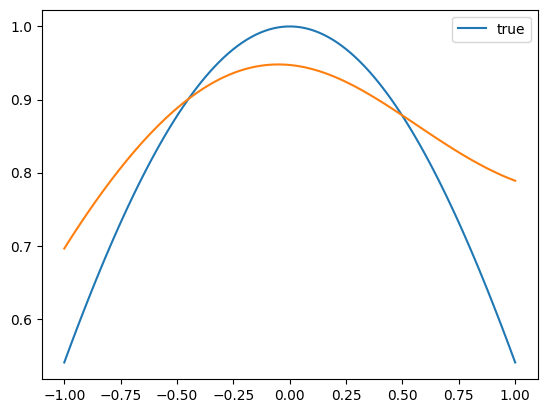

In [635]:
model = SDENet2(input_size=(1,1),
                weight_network_sizes=(1, 32, 1),
                activation='softplus',
                inhomogeneous=True,
                sigma=0.01,
                hidden_width=16,
                aug_dim=2)

kl=1e-3   #1e-3 1-32-1, act1:softplus, act2: tanh, sigma: 0.1, augdim1, hidd=32, inhom=true
lr = 5e-4     #5e-4

X = torch.linspace(-1,1,100).unsqueeze(1).unsqueeze(1)
y = torch.cos(X)

def train(model):

    epochs = 2500

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):

        optimizer.zero_grad()

        output = model(X)[0]
        loss1 = criterion(output, y) 
        loss2 = model(X)[1].mean() * kl
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print('epoch: ', epoch, 'loss: ', loss.item(), 'loss1: ', loss1.item(), 'loss2: ', loss2.item())

    return loss.item()

l = train(model)
print('loss: ', l, 'lr: ', lr, 'activation: ', activation, 'sigma: ', sigma, 'kl: ', kl, 'aug_dim: ', aug_dim)

plt.plot(X.squeeze(1).squeeze(1).numpy(), y.squeeze(1).squeeze(1).numpy(), label='true')

#test = torch.linspace(-1,1,100).unsqueeze(1).unsqueeze(1)

test_output = model(X)[0]    
plt.plot(X.squeeze(1).squeeze(1).numpy(), test_output.detach().numpy())
plt.legend()    
plt.show()

Epoch: 1000, Loss: 0.00032973219640553


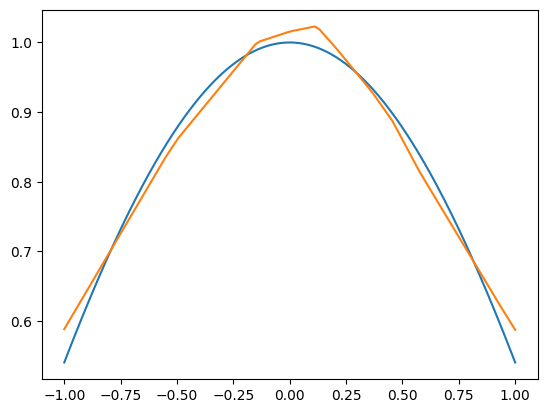

In [601]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Define the model
model = SimpleNN(input_size=1, hidden_size=32, output_size=1)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
for epoch in range(1000):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

# Test the model
test_output = model(test)
plt.plot(X.squeeze().numpy(), y.squeeze().numpy())
plt.plot(test.squeeze().numpy(), test_output.squeeze().detach().numpy())
plt.show()


In [ ]:
X = torch.linspace(-1,1,1000).unsqueeze(1).unsqueeze(1)
y = torch.cos(X)

import tqdm

#X = torch.tensor([-5., 5.]).unsqueeze(1).unsqueeze(1)
#y = torch.tensor([0., 1]).unsqueeze(1).unsqueeze(1)

for lr in tqdm.tqdm([1e-3, 1e-4]):                                                # 1e-2 does not work
    for activation in tqdm.tqdm(['softplus', 'relu', 'tanh']):#, leave=False):
        for sigma in [1e-4, 1e-3,1e-2,1e-1]:
            for aug_dim in [0, 1]:
                for kl in [0, 1e-6, 1e-5, 1e-4, 1e-7]:

                    model = SDENet2(input_size=(1,1),
                                    weight_network_sizes=(1, 32, 1),
                                    activation=activation,
                                    inhomogeneous=False,
                                    sigma=sigma,
                                    hidden_width=32,
                                    aug_dim=aug_dim)

                    def train(model):

                        epochs = 10000

                        optimizer = torch.optim.SGD(model.parameters(), lr=lr)
                        criterion = nn.MSELoss()

                        for epoch in range(epochs):

                            optimizer.zero_grad()

                            output = model(data)[0]
                            loss = criterion(output, y) + model(data)[1].mean() * kl
                            loss.backward()
                            optimizer.step()

                        return loss.item()

                    l = train(model)
                    print('loss: ', l, 'lr: ', lr, 'activation: ', activation, 'sigma: ', sigma, 'kl: ', kl, 'aug_dim: ', aug_dim)

                    plt.plot(X.squeeze(1).squeeze(1).numpy(), y.squeeze(1).squeeze(1).numpy(), label='true')

                    #test = torch.linspace(-1,1,100).unsqueeze(1).unsqueeze(1)

                    test_output = model(X)[0]    
                    plt.plot(X.squeeze(1).squeeze(1).numpy(), test_output.detach().numpy())
                    plt.legend()    
                    plt.show()